In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.nn import leaky_relu
from tensorflow.keras import layers, activations, losses, Model, Input
from tensorflow.keras.utils import plot_model, Progbar
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import SparseCategoricalAccuracy, SparseTopKCategoricalAccuracy
# import tensorflow_ranking as tfr
from sklearn.model_selection import train_test_split
import os, time, gc, json, math, random, re
from tqdm.notebook import tqdm, trange
from matplotlib import pyplot as plt
from joblib import Parallel, delayed
from ast import literal_eval
import multiprocessing
import itertools
from sklearn.metrics.pairwise import cosine_similarity, pairwise_kernels
from itertools import combinations
import matplotlib.pyplot as plt
from scipy import ndimage
import lightgbm as lgb
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)


fea_prod = ['product_sku_hash_id_lag5', 'product_sku_hash_id_lag4', 'product_sku_hash_id_lag3', 
            'product_sku_hash_id_lag2', 'product_sku_hash_id_lag1', 'product_sku_hash_id']
fea_url = ['hashed_url_id_lag5', 'hashed_url_id_lag4', 'hashed_url_id_lag3', 
           'hashed_url_id_lag2', 'hashed_url_id_lag1', 'hashed_url_id']
features = fea_prod + fea_url

INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
def str_to_list(x):
        if not isinstance(x, str) and np.isnan(x):
            return []
        else:
            return literal_eval(x)
        
def add_fea_using_matrix(df, matrix, suffix='_sim', col='product_sku_hash_id', keycol='target_sku'):
    for c in [c for c in df.columns if (c.startswith(col) and bool(re.search('lag[0-9]*$', c))) or (c == col)]:
        if c + suffix not in df.columns:
            df[c + suffix] = matrix[df[c].astype(int), df[keycol].astype(int)]
            print('created ' + c + suffix)

@tf.function
def get_topk_pred(model, x, topk=tf.constant(3)):
    # this is for tf dataset version
    y_pred = model(x, training=False)
    col_to_zero = [naid, minorid]
    tnsr_shape=tf.shape(y_pred['logits'])
    mask = [tf.one_hot(col_num*tf.ones((tnsr_shape[0], ), dtype=tf.int32), tnsr_shape[-1]) for col_num in col_to_zero]
    mask = tf.reduce_sum(mask, axis=0) * -9999
    y_pred['logits'] = tf.add(y_pred['logits'], mask)
    
    # topk items' id for each session, 2d array
    top = tf.math.top_k(y_pred['logits'], k=topk)
    return top.indices, keras.activations.sigmoid(top.values)

def explode(x):
    if x.name in ['neg_sku_list','neg_sku_score']:
        return pd.Series.explode(x)
    else:
        return x


In [3]:
# can simply reuse df_browse_v3_update
df_browse = pd.read_parquet('df_browse_phase2')
# df_browse['sample_weights'] = pd.to_datetime(df_browse.server_day).dt.month

skucate = df_browse.product_sku_hash.cat
num_sku = df_browse.product_sku_hash_id_lag1.max() + 1
num_url = df_browse.hashed_url_id_lag1.max() + 1

# get num_x from x_lag1 because function create_shift_features
# may created a new_id in lag columns
naid = df_browse.product_sku_hash.cat.categories.tolist().index('_')
minorid = df_browse.product_sku_hash.cat.categories.tolist().index('minority')

# note this df_test is used for cal testing MRR later, 
# it is different from the df_test used for training
if not os.path.exists('df_test_phase2'):
    df_test = df_browse[df_browse.train==0].copy()
    df_test = df_test.loc[df_test.next_interacted_sku!=naid]
    df_test.to_parquet('df_test_phase2')
    del df_test
    gc.collect()

if not os.path.exists('df_train_phase2'):
    df_train = df_browse[df_browse.train==1]
    df_train = df_train[(df_train.next_sku!=naid)].reset_index(drop=True)
    # include testing data into training
    df_test = df_browse[df_browse.train==0]
    df_test = df_test[(df_test.next_sku!=naid)].reset_index(drop=True)
    
    def strafiedkfold(df, idcol, k=5):
        """
        sklearn kfold will do unnessary sorting
        so build my own function
        """
        df_kidx = df_train.session_id_hash.unique()
        np.random.seed(123)
        np.random.shuffle(df_kidx)
        df_kidx = pd.DataFrame({idcol: df_kidx})
        df_kidx['kfoldidx'] = df_kidx.index % k
        df = df.merge(df_kidx, on=idcol, copy=False)
        print(df['kfoldidx'].value_counts())
        return df
    
    if 'kfoldidx' in df_train.columns:
        df_train.drop(columns='kfoldidx', inplace=True)
    df_test['kfoldidx'] = 1
    df_train = strafiedkfold(df_train, 'session_id_hash', k=5)
    df_train = pd.concat([df_train, df_test])
    # x_train_weights = df_train.loc[df_train.kfoldidx!=0].sample_weights.reset_index(drop=True)
    df_train.to_parquet('df_train_phase2')

    del df_test, df_train
    gc.collect()

if not os.path.exists('df_submission_phase2'):
    df_submission = df_browse[df_browse.train==0]
    df_submission = df_submission.groupby('session_id_hash').tail(1).reset_index(drop=True)
    df_submission.to_parquet('df_submission_phase2')
    gc.collect()
    
del df_browse
gc.collect()

0

In [4]:
# model architecture
class MLP(Model):
    def __init__(self, num_sku, num_url, embed_dim=312):
        super().__init__()
        
        self.normal_init = keras.initializers.RandomNormal(mean=0., stddev=0.01)
        
        self.sku_embed = layers.Embedding(num_sku, embed_dim, self.normal_init)
        self.url_embed = layers.Embedding(num_url, embed_dim, self.normal_init)
        
        self.dense1 = layers.Dense(1024)
        self.norm1 = layers.BatchNormalization()
        self.activate1 = layers.ReLU()
        self.dropout1 = layers.Dropout(0.2)
        
        self.dense2 = layers.Dense(1024)
        self.norm2 = layers.BatchNormalization()
        self.activate2 = layers.ReLU()
        self.dropout2 = layers.Dropout(0.2)
        
        self.dense3 = layers.Dense(embed_dim)
        self.norm3 = layers.BatchNormalization()
        self.activate3 = layers.ReLU(name='sess_embed')
        self.dropout3 = layers.Dropout(0.2)
        
        self.output_bias = tf.random.normal((num_sku,), 0., 0.01)
    
    def call(self, inputs):
        lag_sku, lag_url = inputs['sku'], inputs['url']
        
        sku_embed = layers.Flatten()(self.sku_embed(lag_sku))
        url_embed = layers.Flatten()(self.url_embed(lag_url))
        
        x = layers.concatenate([sku_embed, url_embed])
        x = self.activate1(self.norm1(self.dense1(x)))
        x = self.dropout1(x)

        x = self.activate2(self.norm2(self.dense2(x)))
        x = self.dropout2(x)

        sess_embed = self.activate3(self.norm3(self.dense3(x)))
        x = self.dropout3(sess_embed)
        
        x = tf.matmul(x, tf.transpose(self.sku_embed.weights[0]))
        logits = tf.nn.bias_add(x, self.output_bias, name='logits')

        return {'logits': logits, 'embed': sess_embed}
    
    def build_graph(self):
        x = {'sku': Input(shape=(6)), 'url': Input(shape=(6))}
        return Model(inputs=x, outputs=self.call(x))
    
    def predict_subset(self, x, u, l):
        _x = []
        for i in range(len(x)):
            _x.append(x[i][u:l])
        return self.predict(_x)
    
keras.utils.plot_model(MLP(num_sku, num_url).build_graph(), show_shapes=False)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [5]:
x_train_one = {'sku': np.random.randint(num_sku, size=(10, 6)), 'url': np.random.randint(num_url, size=(10, 6))}
y_train_one = np.random.randint(num_sku,size=(10,))
tf_train_one = tf.data.Dataset.from_tensor_slices((x_train_one, y_train_one)).batch(2)
del x_train_one, y_train_one
gc.collect()

strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

with strategy.scope():
    model_mlp = MLP(num_sku, num_url)
    LossFunc = {'logits':keras.losses.SparseCategoricalCrossentropy(from_logits=True), 'embed':None}
    metrics = {'logits': [keras.metrics.SparseCategoricalAccuracy(name='top1_acc'), 
                      keras.metrics.SparseTopKCategoricalAccuracy(k=20, name='top20_acc')]}
    model_mlp.compile(optimizer='adam', loss=LossFunc, metrics=metrics)
history = model_mlp.fit(tf_train_one, epochs=1)
model_mlp.load_weights('model_phase2_nn.h5')

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Number of devices: 1
5/5 [==============================] - 6s 420ms/step - loss: 10.6976 - logits_loss: 10.6976 - logits_top1_acc: 0.0000e+00 - logits_top20_acc: 0.0000e+00


In [6]:
# naid = df_browse.product_sku_hash.cat.categories.tolist().index('_')
# minorid = df_browse.product_sku_hash.cat.categories.tolist().index('minority')

@tf.function
def mrr(i, model, x, y, topk=tf.constant(20)):
    # this is for tf dataset version
    interval = tf.shape(y)[0]
    i = tf.cast(i, tf.int32)
    _u = interval * i
    _l = interval * (i+1)
    
    y_pred = model(x, training=False)
    col_to_zero = [naid, minorid]
    tnsr_shape=tf.shape(y_pred['logits'])
    mask = [tf.one_hot(col_num*tf.ones((tnsr_shape[0], ), dtype=tf.int32), tnsr_shape[-1]) for col_num in col_to_zero]
    mask = tf.reduce_sum(mask, axis=0) * -9999
    y_pred['logits'] = tf.add(y_pred['logits'], mask)
    
    # topk items' id for each session, 2d array
    r = tf.math.top_k(y_pred['logits'], k=topk).indices
    # True indicate that item is the correct prediction
    r = tf.cast(tf.equal(r, tf.expand_dims(tf.cast(y, tf.int32), 1)), tf.float32)
    # rank of the correct prediction, rank = 9999999+1 if no correction prediction within topk
    r = tf.add((tf.reduce_sum(r, 1)-1) * -9999999, tf.cast(tf.argmax(r, 1) + 1, tf.float32))
    return 1/r

# Ranking

In [7]:
df_train = pd.read_parquet('df_train_phase2')

In [8]:
# todo: only testing data and validation to test the model for now
df_train = df_train.loc[(df_train.train==0) | (df_train.kfoldidx==0)]
df_train.shape

(2310878, 24)

In [9]:
df_train['idx'] = np.arange(df_train.shape[0])
df_train['n'] = df_train.groupby('session_id_hash').cumcount()

# each original record is treated as a query
df_train['query_id'] = df_train['session_id_hash'] + '_' + df_train['n'].astype(str)

In [10]:
#
# POSITIVE samples
#
s = time.time()

# todo: get next 1 unique sku as pos samples for now
tmp = df_train.groupby('session_id_hash')['next_sku'].agg(list).reset_index()
tmp.columns = ['session_id_hash', 'pos_sku_list']
df_train = df_train.merge(tmp, on='session_id_hash', how='left')

def get_pos_sku_list(x):
    items = x['pos_sku_list'][x['n']:(x['n'] + 1)]
    # if items = [46639.0, 46639.0, 16598.0, 25232.0, 46639.0]
    # return [46639, 16598, 25232] <- length depends on hard coded number above
    return list(dict.fromkeys(items))

df_train['pos_sku_list'] = df_train[['pos_sku_list','n']].parallel_apply(get_pos_sku_list, axis = 1)

print(time.time()-s)

del tmp
gc.collect()

22.786654472351074


0

In [11]:
#
# NEGATIVE Samples
#

# get top k pred for each record
batch_size = 2000
tf_all = tf.data.Dataset.from_tensor_slices({'sku':df_train[fea_prod].values, 'url':df_train[fea_url].values}).batch(batch_size)
dist_all = strategy.experimental_distribute_dataset(tf_all)

# take around 200s
s = time.time()

neg_sku_list = []
score_list = []
i = tf.constant(0)
#todo: rerank only top 20 for now
topk = tf.constant(20)

for x in dist_all:
    _sku_ids, _scores = strategy.run(get_topk_pred, args=(model_mlp, x, topk))
    score_list.append(_scores)
    neg_sku_list.append(_sku_ids)
    i += 1
    if i % 1000 == 0:
        print(i, time.time()-s)

s= time.time()

neg_sku_list = list(map(lambda x: list(map(list, x.numpy())), neg_sku_list))
neg_sku_list = [item for sublist in neg_sku_list for item in sublist]

score_list = list(map(lambda x: list(map(list, x.numpy())), score_list))
score_list = [item for sublist in score_list for item in sublist]

df_train['neg_sku_list'] = neg_sku_list
df_train['neg_sku_score'] = score_list

print(time.time()-s)

del tf_all, dist_all
gc.collect()

tf.Tensor(1000, shape=(), dtype=int32) 206.6548457145691
13.957698822021484


106

In [12]:
# remove queries if no pos sample in neg_sku_list
s= time.time()

def get_neg_sku_list(x):
    items = x['pos_sku_list']
    for i in items: 
        if i in x['neg_sku_list']:
            return 1
    return 0

# further split it into "chunk"
# because if df_train gets too large, pickle in parallel_apply takes too long
chunk = 1
interval = int(np.ceil(df_train.shape[0] / chunk))
pos_in_neg_sku_list = []
for j in range(chunk):
    pos_in_neg_sku_list = pos_in_neg_sku_list + df_train.loc[(interval*j):(interval*(j+1)), ['neg_sku_list','pos_sku_list']].parallel_apply(get_neg_sku_list, axis = 1).tolist()
    print(time.time()-s)

df_train['pos_in_neg'] = pos_in_neg_sku_list
df_train = df_train.loc[df_train.pos_in_neg==1]
df_train.drop(columns='pos_in_neg', inplace=True)

del neg_sku_list, pos_in_neg_sku_list
gc.collect()

130.4589080810547


0

In [13]:
# explode score and neg_sku_list
df_train = df_train.apply(explode).reset_index(drop=True)

In [14]:
df_train['target_sku'] = df_train['neg_sku_list']

In [15]:
# add label for each sku
# i indexed sku in pos_sku_list has score of len(pos_sku_list) - i
def get_sku_label(x):
    if x['target_sku'] not in x['pos_sku_list']:
        return 0 
    else:
        pos_sku_list = list(x['pos_sku_list'])
        return len(pos_sku_list) - pos_sku_list.index(x['target_sku'])

df_train['label'] = df_train[['pos_sku_list','target_sku']].parallel_apply(lambda x: get_sku_label(x), axis = 1) 

In [16]:
df_train.drop(columns=['pos_sku_list','neg_sku_list'], inplace=True)

In [20]:
#
# Prepare item by item matrix
# 1. sku similarity
# 2. description similarity
# 3. same category
# 4. same price
# 5. image similarity
#

if not os.path.exists('sku_sim_phase2.npy'):
    print('creating sku_sim')
    sku_embed = model_mlp.sku_embed.get_weights()[0]
    sku_sim = pairwise_kernels(sku_embed, sku_embed, metric='cosine', n_jobs=-1)
    np.save('sku_sim_phase2', sku_sim)
    del sku_embed, sku_sim
    gc.collect()
    
if not os.path.exists('desc_sim_phase2.npy') or not os.path.exists('img_sim_phase2.npy') or not os.path.exists('cate_same_phase2.npy') or not os.path.exists('price_same_phase2.npy'):
    df_sku = pd.read_csv("./data/sku_to_content.csv")
    df_sku['description_vector_l'] = df_sku.description_vector.apply(str_to_list)
    df_sku['image_vector_l'] = df_sku.image_vector.apply(str_to_list)
    
    # cate and price of each sku
    df_skuid_cate_price = pd.DataFrame(skucate.categories)
    df_skuid_cate_price.columns = ['product_sku_hash']
    df_skuid_cate_price = df_skuid_cate_price.merge(df_sku[['product_sku_hash', 'category_hash', 'price_bucket']], how='left', on='product_sku_hash')
    assert df_skuid_cate_price.shape[0] == num_sku, 'more than 1 cate or price for some skus'

    # get desc/img embed
    def get_descimg_embed(idx, col='description_vector_l'):
        try:
            sku = skucate.categories[idx]
            embed = df_sku[col][df_sku.product_sku_hash==sku].values[0]
            if len(embed) == 0:
                return np.zeros(50)
            else:
                return embed
        except (IndexError, ValueError):
            return np.zeros(50)
            
    if not os.path.exists('desc_sim_phase2.npy'):
        print('creating desc_sim')
        desc_embed = Parallel(n_jobs=multiprocessing.cpu_count(), backend='multiprocessing')(delayed(get_descimg_embed)(i) for i in trange(num_sku))
        desc_embed = np.array(desc_embed)
        desc_sim = pairwise_kernels(desc_embed, desc_embed, metric='cosine', n_jobs=-1)
        desc_sim = desc_sim.astype(np.float32)
        np.save('desc_sim_phase2', desc_sim)
        del desc_embed, desc_sim
        gc.collect()
    
    if not os.path.exists('img_sim_phase2.npy'):
        print('creating img_sim')
        img_embed = Parallel(n_jobs=multiprocessing.cpu_count(), backend='multiprocessing')(delayed(get_descimg_embed)(i, 'image_vector_l') for i in trange(num_sku))
        img_embed = np.array(img_embed)
        img_sim = pairwise_kernels(img_embed, img_embed, metric='cosine', n_jobs=-1)
        img_sim = img_sim.astype(np.float32)
        np.save('img_sim_phase2', img_sim)
        del img_embed, img_sim
        gc.collect()
     
    if not os.path.exists('cate_same_phase2.npy'):
        print('creating cate_same')
        cate_same = np.array(df_skuid_cate_price.category_hash)
        cate_same = (cate_same == np.expand_dims(cate_same, 1)).astype(np.int8)
        np.save('cate_same_phase2', cate_same)
        del cate_same
        gc.collect()
    
    if not os.path.exists('price_same_phase2.npy'):
        print('creating price_same')
        price_same = np.array(df_skuid_cate_price.category_hash)
        price_same = (price_same == np.expand_dims(price_same, 1)).astype(np.int8)
        np.save('price_same_phase2', price_same)
        del price_same
        gc.collect()
    
    del df_skuid_cate_price, df_sku
    gc.collect()
    

creating sku_sim
creating desc_sim


  0%|          | 0/41450 [00:00<?, ?it/s]

creating img_sim


  0%|          | 0/41450 [00:00<?, ?it/s]

creating cate_same
creating price_same


In [21]:
# add features
for matrix, suffix in zip(*[('sku_sim','desc_sim','img_sim','cate_same','price_same'),('_sim','_descsim','_imgsim','_catesame','_pricesame')]):
    matrix = np.load(matrix + '_phase2.npy')
    add_fea_using_matrix(df_train, matrix, suffix, 'product_sku_hash_id', 'target_sku')
    del matrix
    gc.collect()

created product_sku_hash_id_sim
created product_sku_hash_id_lag1_sim
created product_sku_hash_id_lag2_sim
created product_sku_hash_id_lag3_sim
created product_sku_hash_id_lag4_sim
created product_sku_hash_id_lag5_sim
created product_sku_hash_id_descsim
created product_sku_hash_id_lag1_descsim
created product_sku_hash_id_lag2_descsim
created product_sku_hash_id_lag3_descsim
created product_sku_hash_id_lag4_descsim
created product_sku_hash_id_lag5_descsim
created product_sku_hash_id_imgsim
created product_sku_hash_id_lag1_imgsim
created product_sku_hash_id_lag2_imgsim
created product_sku_hash_id_lag3_imgsim
created product_sku_hash_id_lag4_imgsim
created product_sku_hash_id_lag5_imgsim
created product_sku_hash_id_catesame
created product_sku_hash_id_lag1_catesame
created product_sku_hash_id_lag2_catesame
created product_sku_hash_id_lag3_catesame
created product_sku_hash_id_lag4_catesame
created product_sku_hash_id_lag5_catesame
created product_sku_hash_id_pricesame
created product_sku_ha

In [7]:
# df_train.to_parquet('df_train_final_phase2')
df_train = pd.read_parquet('df_train_final_phase2')

In [8]:
df_train.columns

Index(['session_id_hash', 'event_type', 'product_action', 'product_sku_hash',
       'server_timestamp_epoch_ms', 'hashed_url', 'train', 'server_day',
       'product_sku_hash_id', 'hashed_url_id', 'product_sku_hash_id_lag1',
       'product_sku_hash_id_lag2', 'product_sku_hash_id_lag3',
       'product_sku_hash_id_lag4', 'product_sku_hash_id_lag5',
       'hashed_url_id_lag1', 'hashed_url_id_lag2', 'hashed_url_id_lag3',
       'hashed_url_id_lag4', 'hashed_url_id_lag5', 'next_sku',
       'next_interacted_sku', 'rand_id', 'kfoldidx', 'idx', 'n', 'query_id',
       'neg_sku_score', 'target_sku', 'label', 'product_sku_hash_id_sim',
       'product_sku_hash_id_lag1_sim', 'product_sku_hash_id_lag2_sim',
       'product_sku_hash_id_lag3_sim', 'product_sku_hash_id_lag4_sim',
       'product_sku_hash_id_lag5_sim', 'product_sku_hash_id_descsim',
       'product_sku_hash_id_lag1_descsim', 'product_sku_hash_id_lag2_descsim',
       'product_sku_hash_id_lag3_descsim', 'product_sku_hash_id_lag4_d

In [9]:
fea_lambdarank = [
    'product_sku_hash_id_sim', 'product_sku_hash_id_lag1_sim',
    'product_sku_hash_id_lag2_sim', 'product_sku_hash_id_lag3_sim',
    'product_sku_hash_id_lag4_sim', 'product_sku_hash_id_lag5_sim',
    'product_sku_hash_id_descsim', 'product_sku_hash_id_lag1_descsim',
    'product_sku_hash_id_lag2_descsim', 'product_sku_hash_id_lag3_descsim',
    'product_sku_hash_id_lag4_descsim', 'product_sku_hash_id_lag5_descsim',
    'product_sku_hash_id_imgsim', 'product_sku_hash_id_lag1_imgsim',
    'product_sku_hash_id_lag2_imgsim', 'product_sku_hash_id_lag3_imgsim',
    'product_sku_hash_id_lag4_imgsim', 'product_sku_hash_id_lag5_imgsim',
    'product_sku_hash_id_catesame', 'product_sku_hash_id_lag1_catesame',
    'product_sku_hash_id_lag2_catesame',
    'product_sku_hash_id_lag3_catesame',
    'product_sku_hash_id_lag4_catesame',
    'product_sku_hash_id_lag5_catesame', 'product_sku_hash_id_pricesame',
    'product_sku_hash_id_lag1_pricesame',
    'product_sku_hash_id_lag2_pricesame',
    'product_sku_hash_id_lag3_pricesame',
    'product_sku_hash_id_lag4_pricesame',
    'product_sku_hash_id_lag5_pricesame',
    'neg_sku_score'
]

In [10]:
dtrain_x = df_train.loc[df_train.kfoldidx!=0, fea_lambdarank].values
dval_x = df_train.loc[df_train.kfoldidx==0, fea_lambdarank].values

In [11]:
dtrain_group = df_train.loc[df_train.kfoldidx!=0].groupby('query_id')['query_id'].count().values
dval_group = df_train.loc[df_train.kfoldidx==0].groupby('query_id')['query_id'].count().values

In [12]:
df_train['label'] = df_train['label'].astype(int)
dtrain_y = df_train.loc[df_train.kfoldidx!=0, 'label'].values
dval_y = df_train.loc[df_train.kfoldidx==0, 'label'].values

In [13]:
lgb_train = lgb.Dataset(dtrain_x, dtrain_y, group=dtrain_group, free_raw_data=False)
lgb_train.set_group(dtrain_group)

lgb_val = lgb.Dataset(dval_x, dval_y, group=dval_group, free_raw_data=False)
lgb_val.set_group(dval_group)


In [14]:
params= {
    'objective': 'lambdarank',
    'boosting_type': 'gbdt',
    'num_leaves': 128,
    'feature_fraction': 0.2,
    'bagging_fraction': 0.2,
    'max_bin': 256,
    'learning_rate': 0.05,
    'metric': 'ndcg',
    'eval_at': (1, 5, 20),
    'first_metric_only': True
}

model_lgb = lgb.train(params, lgb_train, valid_sets=[lgb_val], num_boost_round=1000, early_stopping_rounds=100)
gc.collect()

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.294530 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4888
[LightGBM] [Info] Number of data points in the train set: 6507760, number of used features: 31
[1]	valid_0's ndcg@1: 0.610068	valid_0's ndcg@5: 0.756103	valid_0's ndcg@20: 0.791418
Training until validation scores don't improve for 100 rounds
[2]	valid_0's ndcg@1: 0.202651	valid_0's ndcg@5: 0.393877	valid_0's ndcg@20: 0.5164
[3]	valid_0's ndcg@1: 0.211824	valid_0's ndcg@5: 0.408515	valid_0's ndcg@20: 0.52535
[4]	valid_0's ndcg@1: 0.604895	valid_0's ndcg@5: 0.76319	valid_0's ndcg@20: 0.794512
[5]	valid_0's ndcg@1: 0.584092	valid_0's ndcg@5: 0.754994	valid_0's ndcg@20: 0.786356
[6]	valid_0's ndcg@1: 0.564919	valid_0's ndcg@5: 0.746653	valid_0's ndcg@20: 0.778283
[7]	valid_0's ndcg@1: 0.556895	valid_0's ndcg@5: 0.74295	valid_0's n

[91]	valid_0's ndcg@1: 0.728014	valid_0's ndcg@5: 0.827807	valid_0's ndcg@20: 0.852759
[92]	valid_0's ndcg@1: 0.728506	valid_0's ndcg@5: 0.828055	valid_0's ndcg@20: 0.852989
[93]	valid_0's ndcg@1: 0.728417	valid_0's ndcg@5: 0.828014	valid_0's ndcg@20: 0.852945
[94]	valid_0's ndcg@1: 0.728416	valid_0's ndcg@5: 0.828006	valid_0's ndcg@20: 0.852939
[95]	valid_0's ndcg@1: 0.729003	valid_0's ndcg@5: 0.828313	valid_0's ndcg@20: 0.853221
[96]	valid_0's ndcg@1: 0.729468	valid_0's ndcg@5: 0.828524	valid_0's ndcg@20: 0.853421
[97]	valid_0's ndcg@1: 0.729906	valid_0's ndcg@5: 0.828769	valid_0's ndcg@20: 0.853633
[98]	valid_0's ndcg@1: 0.729794	valid_0's ndcg@5: 0.828703	valid_0's ndcg@20: 0.853573
[99]	valid_0's ndcg@1: 0.72973	valid_0's ndcg@5: 0.828642	valid_0's ndcg@20: 0.853534
[100]	valid_0's ndcg@1: 0.730203	valid_0's ndcg@5: 0.828858	valid_0's ndcg@20: 0.85375
[101]	valid_0's ndcg@1: 0.730131	valid_0's ndcg@5: 0.828786	valid_0's ndcg@20: 0.853689
[102]	valid_0's ndcg@1: 0.730109	valid_0's 

[185]	valid_0's ndcg@1: 0.734486	valid_0's ndcg@5: 0.830456	valid_0's ndcg@20: 0.855465
[186]	valid_0's ndcg@1: 0.734483	valid_0's ndcg@5: 0.830449	valid_0's ndcg@20: 0.855462
[187]	valid_0's ndcg@1: 0.734499	valid_0's ndcg@5: 0.830446	valid_0's ndcg@20: 0.855461
[188]	valid_0's ndcg@1: 0.73449	valid_0's ndcg@5: 0.830436	valid_0's ndcg@20: 0.855452
[189]	valid_0's ndcg@1: 0.734397	valid_0's ndcg@5: 0.830392	valid_0's ndcg@20: 0.855414
[190]	valid_0's ndcg@1: 0.734423	valid_0's ndcg@5: 0.830399	valid_0's ndcg@20: 0.855419
[191]	valid_0's ndcg@1: 0.73446	valid_0's ndcg@5: 0.830406	valid_0's ndcg@20: 0.855434
[192]	valid_0's ndcg@1: 0.734457	valid_0's ndcg@5: 0.830406	valid_0's ndcg@20: 0.855436
[193]	valid_0's ndcg@1: 0.734447	valid_0's ndcg@5: 0.830392	valid_0's ndcg@20: 0.855426
[194]	valid_0's ndcg@1: 0.734467	valid_0's ndcg@5: 0.830391	valid_0's ndcg@20: 0.855431
[195]	valid_0's ndcg@1: 0.734532	valid_0's ndcg@5: 0.830419	valid_0's ndcg@20: 0.85546
[196]	valid_0's ndcg@1: 0.734492	va

[279]	valid_0's ndcg@1: 0.735756	valid_0's ndcg@5: 0.830909	valid_0's ndcg@20: 0.855974
[280]	valid_0's ndcg@1: 0.735781	valid_0's ndcg@5: 0.830926	valid_0's ndcg@20: 0.855988
[281]	valid_0's ndcg@1: 0.735771	valid_0's ndcg@5: 0.830913	valid_0's ndcg@20: 0.855984
[282]	valid_0's ndcg@1: 0.735823	valid_0's ndcg@5: 0.830947	valid_0's ndcg@20: 0.856011
[283]	valid_0's ndcg@1: 0.735814	valid_0's ndcg@5: 0.830938	valid_0's ndcg@20: 0.856005
[284]	valid_0's ndcg@1: 0.735814	valid_0's ndcg@5: 0.830919	valid_0's ndcg@20: 0.855995
[285]	valid_0's ndcg@1: 0.735807	valid_0's ndcg@5: 0.830918	valid_0's ndcg@20: 0.855996
[286]	valid_0's ndcg@1: 0.735781	valid_0's ndcg@5: 0.830903	valid_0's ndcg@20: 0.85598
[287]	valid_0's ndcg@1: 0.735855	valid_0's ndcg@5: 0.830937	valid_0's ndcg@20: 0.856014
[288]	valid_0's ndcg@1: 0.735862	valid_0's ndcg@5: 0.830939	valid_0's ndcg@20: 0.856016
[289]	valid_0's ndcg@1: 0.735846	valid_0's ndcg@5: 0.830932	valid_0's ndcg@20: 0.856008
[290]	valid_0's ndcg@1: 0.735937	

[373]	valid_0's ndcg@1: 0.736026	valid_0's ndcg@5: 0.830882	valid_0's ndcg@20: 0.855997
[374]	valid_0's ndcg@1: 0.736023	valid_0's ndcg@5: 0.830873	valid_0's ndcg@20: 0.855993
[375]	valid_0's ndcg@1: 0.736023	valid_0's ndcg@5: 0.830873	valid_0's ndcg@20: 0.855993
[376]	valid_0's ndcg@1: 0.736046	valid_0's ndcg@5: 0.830891	valid_0's ndcg@20: 0.856008
[377]	valid_0's ndcg@1: 0.736053	valid_0's ndcg@5: 0.830889	valid_0's ndcg@20: 0.85601
[378]	valid_0's ndcg@1: 0.736041	valid_0's ndcg@5: 0.830885	valid_0's ndcg@20: 0.856007
[379]	valid_0's ndcg@1: 0.736029	valid_0's ndcg@5: 0.830881	valid_0's ndcg@20: 0.856002
[380]	valid_0's ndcg@1: 0.736024	valid_0's ndcg@5: 0.830882	valid_0's ndcg@20: 0.856001
[381]	valid_0's ndcg@1: 0.736106	valid_0's ndcg@5: 0.830915	valid_0's ndcg@20: 0.856033
[382]	valid_0's ndcg@1: 0.736103	valid_0's ndcg@5: 0.830916	valid_0's ndcg@20: 0.856031
[383]	valid_0's ndcg@1: 0.736102	valid_0's ndcg@5: 0.830912	valid_0's ndcg@20: 0.856029
[384]	valid_0's ndcg@1: 0.736093	

1417

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

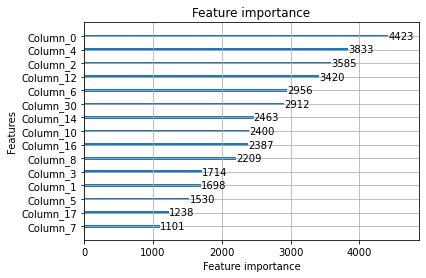

In [15]:
lgb.plot_importance(model_lgb, max_num_features=15)

In [16]:
np.array(fea_lambdarank)[[0,4,2,12,6,30,14,10,16,8,3,1,5,17,7]]

array(['product_sku_hash_id_sim', 'product_sku_hash_id_lag4_sim',
       'product_sku_hash_id_lag2_sim', 'product_sku_hash_id_imgsim',
       'product_sku_hash_id_descsim', 'neg_sku_score',
       'product_sku_hash_id_lag2_imgsim',
       'product_sku_hash_id_lag4_descsim',
       'product_sku_hash_id_lag4_imgsim',
       'product_sku_hash_id_lag2_descsim', 'product_sku_hash_id_lag3_sim',
       'product_sku_hash_id_lag1_sim', 'product_sku_hash_id_lag5_sim',
       'product_sku_hash_id_lag5_imgsim',
       'product_sku_hash_id_lag1_descsim'], dtype='<U34')

In [17]:
# this takes too many memory
del df_train
gc.collect()

40

In [18]:
del lgb_train, lgb_val, dtrain_x, dval_x, dtrain_y, dval_y, dtrain_group, dval_group
gc.collect()

20

In [19]:
df_test = pd.read_parquet('df_test_phase2')

In [20]:
df_test['n'] = df_test.groupby('session_id_hash').cumcount()
df_test['query_id'] = df_test['session_id_hash'] + '_' + df_test['n'].astype(str)

In [21]:
# get topK predicted sku list in test set
batch_size = 2000
tf_test = tf.data.Dataset.from_tensor_slices({'sku':df_test[fea_prod].values, 'url':df_test[fea_url].values}).batch(batch_size)
dist_test = strategy.experimental_distribute_dataset(tf_test)

# take around 200s
s = time.time()

neg_sku_list = []
score_list = []
i = tf.constant(0)
topk=tf.constant(20)

for x in dist_test:
    _sku_ids, _scores = strategy.run(get_topk_pred, args=(model_mlp, x, topk))
    score_list.append(_scores)
    neg_sku_list.append(_sku_ids)
    i += 1
    if i % 100 == 0:
        print(i, time.time()-s)
        
neg_sku_list = list(map(lambda x: list(map(list, x.numpy())), neg_sku_list))
neg_sku_list = [item for sublist in neg_sku_list for item in sublist]

score_list = list(map(lambda x: list(map(list, x.numpy())), score_list))
score_list = [item for sublist in score_list for item in sublist]

df_test['neg_sku_list'] = neg_sku_list
df_test['neg_sku_score'] = score_list
del neg_sku_list, score_list
gc.collect()

tf.Tensor(100, shape=(), dtype=int32) 23.414361238479614
tf.Tensor(200, shape=(), dtype=int32) 42.785645484924316
tf.Tensor(300, shape=(), dtype=int32) 62.248645067214966


0

In [22]:
# explode df_test with topK sku
df_test = df_test.apply(explode).reset_index(drop=True)
df_test = df_test.rename(columns = {'neg_sku_list': 'target_sku'})

In [23]:
# add features
for matrix, suffix in zip(*[('sku_sim','desc_sim','img_sim','cate_same','price_same'),('_sim','_descsim','_imgsim','_catesame','_pricesame')]):
    matrix = np.load(matrix + '_phase2.npy')
    add_fea_using_matrix(df_test, matrix, suffix, 'product_sku_hash_id', 'target_sku')
    del matrix
    gc.collect()

created product_sku_hash_id_sim
created product_sku_hash_id_lag1_sim
created product_sku_hash_id_lag2_sim
created product_sku_hash_id_lag3_sim
created product_sku_hash_id_lag4_sim
created product_sku_hash_id_lag5_sim
created product_sku_hash_id_descsim
created product_sku_hash_id_lag1_descsim
created product_sku_hash_id_lag2_descsim
created product_sku_hash_id_lag3_descsim
created product_sku_hash_id_lag4_descsim
created product_sku_hash_id_lag5_descsim
created product_sku_hash_id_imgsim
created product_sku_hash_id_lag1_imgsim
created product_sku_hash_id_lag2_imgsim
created product_sku_hash_id_lag3_imgsim
created product_sku_hash_id_lag4_imgsim
created product_sku_hash_id_lag5_imgsim
created product_sku_hash_id_catesame
created product_sku_hash_id_lag1_catesame
created product_sku_hash_id_lag2_catesame
created product_sku_hash_id_lag3_catesame
created product_sku_hash_id_lag4_catesame
created product_sku_hash_id_lag5_catesame
created product_sku_hash_id_pricesame
created product_sku_ha

In [24]:
# predict for df_test
y_pred_test = model_lgb.predict(df_test[fea_lambdarank].values)
df_test['label_pred'] = y_pred_test
del y_pred_test
gc.collect()

24

In [25]:
# sort df_test by query_id, and label_pred descending
df_test.sort_values(['query_id','label_pred'], ascending=False, inplace=True)

In [26]:
# implode df_test: groupby (query_id, next_sku) agg list
df_test_r = pd.DataFrame(df_test.groupby(['query_id', 'session_id_hash','next_interacted_sku', 'next_sku', 'rand_id']).agg({'label_pred':list, 'target_sku': list})).reset_index()


In [27]:
def get_r(x):
    try:
        return x['target_sku'][0:20].index(x['next_interacted_sku']) + 1
    except ValueError:
        return 1000000

df_test_r['r'] = df_test_r[['target_sku','next_interacted_sku']].parallel_apply(get_r, axis=1)
df_test_r['rr'] = 1/df_test_r['r']

In [28]:
topk=tf.constant(20)

rr = df_test_r.rr.values
print('MRR=%.4f'%np.mean(rr))
out_rr = (rr<1/20)
print('%d out of %d records (%.2f%%) with prediction outside top%d'%(
    out_rr.sum(), out_rr.shape[0], (out_rr.mean())*100., topk.numpy()), flush=True)

print('---------------------------')
print('random pick one per session')
cond = df_test_r.groupby(['session_id_hash'])['rand_id'].transform(min) == df_test_r['rand_id']
print('MRR=%.4f ' % np.mean(rr[cond]))
print('%d out of %d sessions (%.2f%%) with prediction outside top%d'%(
    out_rr[cond].sum(), out_rr[cond].shape[0], (out_rr[cond].mean())*100., topk.numpy()), flush=True)

MRR=0.2954
325322 out of 729674 records (44.58%) with prediction outside top20
---------------------------
random pick one per session
MRR=0.3473 
43991 out of 122524 sessions (35.90%) with prediction outside top20


In [29]:
del df_test, df_test_r
# del model_lgb
gc.collect()

40

## prepare submission

In [30]:
df_submission = pd.read_parquet('df_submission_phase2')

In [31]:
df_submission.head()

,session_id_hash,event_type,product_action,product_sku_hash,server_timestamp_epoch_ms,hashed_url,train,server_day,product_sku_hash_id,hashed_url_id,...,product_sku_hash_id_lag4,product_sku_hash_id_lag5,hashed_url_id_lag1,hashed_url_id_lag2,hashed_url_id_lag3,hashed_url_id_lag4,hashed_url_id_lag5,next_sku,next_interacted_sku,rand_id
0,000001cc2b6d024f5c1d93536c2f22e7adb3f390ff0212...,event_product,detail,bcec4bf55cb2f4db39c5879275c5ed222beb4b2594d4ad...,2019-05-07 16:47:35.055,8b1bbbcf517f7a82d881a9bc3683043946b6b289f5afd7...,0,2019-05-07,30687,132246,...,26085,26085,243408,243408,243408,243408,243408,26085,26085.0,0
1,000064267054198e2f5744100c27111c0d0d585dd73e7e...,event_product,detail,9ce84651a32cf3e8bf5dd782f3664693b92403e7abc8d2...,2019-04-26 03:47:46.867,a8edd7e105e2bc9be3ac8d5aa5737b1ad19d4de4459679...,0,2019-04-26,25574,160737,...,26085,26085,66297,243408,243408,243408,243408,26085,26085.0,0
2,0000976bb88afb92b355acdad71a8951472b1c611d31c4...,pageview,None,_,2019-05-04 18:36:52.459,22c1ce2d23943c5180f95685abe9b0ce6d2046a6586c18...,0,2019-05-04,26085,32992,...,26085,26085,243407,32992,16335,32992,5166,26085,26085.0,8
3,00009b888f49f538ee3efe2a897e96ce98003b8a9f9f70...,event_product,detail,fa2f22b63f20f974310deec8da2c76b6fb0057683a0cea...,2019-05-07 15:20:54.646,56cd97d94a4bd9f558d2a816e8ae23ceffe36b0b99ed44...,0,2019-05-07,40511,82535,...,26085,26085,221005,221005,64034,24339,243408,26085,26085.0,4
4,0000b30a047691fe5754ff7371fa94df09bf39b8745f94...,event_product,detail,409308a78b45af2d988eef583eb35a80cb5c89f294f771...,2019-04-25 17:34:06.282,61b436fd7cccddb68485f7d0825d1c9d0dec0a1b49f7c6...,0,2019-04-25,10586,92995,...,26085,26085,243408,243408,243408,243408,243408,26085,26085.0,0


In [32]:
# get topK predicted sku list in test set
batch_size = 2000
tf_submission = tf.data.Dataset.from_tensor_slices({'sku':df_submission[fea_prod].values, 'url':df_submission[fea_url].values}).batch(batch_size)
dist_submission = strategy.experimental_distribute_dataset(tf_submission)

# take around 200s
s = time.time()

neg_sku_list = []
score_list = []
i = tf.constant(0)
topk=tf.constant(20)

for x in dist_submission:
    _sku_ids, _scores = strategy.run(get_topk_pred, args=(model_mlp, x, topk))
    score_list.append(_scores)
    neg_sku_list.append(_sku_ids)
    i += 1
    if i % 100 == 0:
        print(i, time.time()-s)
        
neg_sku_list = list(map(lambda x: list(map(list, x.numpy())), neg_sku_list))
neg_sku_list = [item for sublist in neg_sku_list for item in sublist]

score_list = list(map(lambda x: list(map(list, x.numpy())), score_list))
score_list = [item for sublist in score_list for item in sublist]

df_submission['neg_sku_list'] = neg_sku_list
df_submission['neg_sku_score'] = score_list
del neg_sku_list, score_list
gc.collect()

tf.Tensor(100, shape=(), dtype=int32) 19.632309675216675


0

In [33]:
df_submission = df_submission.apply(explode).reset_index(drop=True)
df_submission = df_submission.rename(columns = {'neg_sku_list': 'target_sku'})

In [34]:
# add features
for matrix, suffix in zip(*[('sku_sim','desc_sim','img_sim','cate_same','price_same'),('_sim','_descsim','_imgsim','_catesame','_pricesame')]):
    matrix = np.load(matrix + '_phase2.npy')
    add_fea_using_matrix(df_submission, matrix, suffix, 'product_sku_hash_id', 'target_sku')
    del matrix
    gc.collect()

created product_sku_hash_id_sim
created product_sku_hash_id_lag1_sim
created product_sku_hash_id_lag2_sim
created product_sku_hash_id_lag3_sim
created product_sku_hash_id_lag4_sim
created product_sku_hash_id_lag5_sim
created product_sku_hash_id_descsim
created product_sku_hash_id_lag1_descsim
created product_sku_hash_id_lag2_descsim
created product_sku_hash_id_lag3_descsim
created product_sku_hash_id_lag4_descsim
created product_sku_hash_id_lag5_descsim
created product_sku_hash_id_imgsim
created product_sku_hash_id_lag1_imgsim
created product_sku_hash_id_lag2_imgsim
created product_sku_hash_id_lag3_imgsim
created product_sku_hash_id_lag4_imgsim
created product_sku_hash_id_lag5_imgsim
created product_sku_hash_id_catesame
created product_sku_hash_id_lag1_catesame
created product_sku_hash_id_lag2_catesame
created product_sku_hash_id_lag3_catesame
created product_sku_hash_id_lag4_catesame
created product_sku_hash_id_lag5_catesame
created product_sku_hash_id_pricesame
created product_sku_ha

In [35]:
# predict for df_submission
y_pred_sub = model_lgb.predict(df_submission[fea_lambdarank].values)
df_submission['label_pred'] = y_pred_sub
del y_pred_sub
gc.collect()

# sort df_test by query_id, and label_pred descending
df_submission.sort_values(['session_id_hash','label_pred'], ascending=False, inplace=True)
df_submission = pd.DataFrame(df_submission.groupby(['session_id_hash',]).agg({'label_pred':list, 'target_sku': list})).reset_index()


In [36]:
test_file='./data/rec_test_phase_2.json'
with open(test_file) as json_file:
    # read the test cases from the provided file
    test_queries = json.load(json_file)

In [37]:
def set_submission(q):
    sess_id = q['query'][0]['session_id_hash']
    try:
        next_sku_id = df_submission.loc[df_submission.session_id_hash == sess_id, 'target_sku'].values[0][0:20]
        next_sku = skucate.categories[next_sku_id].tolist()
    except (ValueError, IndexError):
        # query with only search events not exists in df_test
        next_sku = np.random.choice(skucate.categories, 20, False).tolist()
    
    # copy the test case
    _pred = dict(q)

    # append the label - which needs to be a list
    _pred["label"] = next_sku
    return _pred


In [38]:
my_predictions = Parallel(n_jobs=multiprocessing.cpu_count(), backend='multiprocessing')(delayed(set_submission)(q) for q in tqdm(test_queries))
# check for consistency
assert len(my_predictions) == len(test_queries)
# print out some "coverage"
# print("Predictions made in {} out of {} total test cases".format(cnt_preds, len(test_queries)))

  0%|          | 0/332247 [00:00<?, ?it/s]

In [39]:
EMAIL = ''
local_prediction_file = '{}_{}.json'.format(EMAIL.replace('@', '_'), round(time.time() * 1000))
# dump to file
with open(local_prediction_file, 'w') as outfile:
    json.dump(my_predictions, outfile, indent=2)

In [40]:
print(local_prediction_file)

louiskitlung_connect.hku.hk_1623862966134.json


In [41]:
from dotenv import load_dotenv
from datetime import datetime
import boto3
load_dotenv(verbose=True, dotenv_path='./submission/upload.env')

BUCKET_NAME = os.getenv('BUCKET_NAME') # you received it in your e-mail
EMAIL = os.getenv('EMAIL') # the e-mail you used to sign up
PARTICIPANT_ID = os.getenv('PARTICIPANT_ID') # you received it in your e-mail
AWS_ACCESS_KEY = os.getenv('AWS_ACCESS_KEY') # you received it in your e-mail
AWS_SECRET_KEY = os.getenv('AWS_SECRET_KEY') # you received it in your e-mail

def upload_submission(
        local_file: str,
        task: str
):
    """
    Thanks to Alex Egg for catching the bug!

    :param local_file: local path, may be only the file name or a full path
    :param task: rec or cart
    :return:
    """

    print("Starting submission at {}...\n".format(datetime.utcnow()))
    # instantiate boto3 client
    s3_client = boto3.client(
        's3',
        aws_access_key_id=AWS_ACCESS_KEY ,
        aws_secret_access_key=AWS_SECRET_KEY,
        region_name='us-west-2'
    )
    s3_file_name = os.path.basename(local_file)
    # prepare s3 path according to the spec
    s3_file_path = '{}/{}/{}'.format(task, PARTICIPANT_ID, s3_file_name)  # it needs to be like e.g. "rec/id/*.json"
    # upload file
    s3_client.upload_file(local_file, BUCKET_NAME, s3_file_path)
    # say bye
    print("\nAll done at {}: see you, space cowboy!".format(datetime.utcnow()))

    return


In [42]:
upload_submission(local_file=local_prediction_file, task='rec')

Starting submission at 2021-06-16 17:03:10.898764...


All done at 2021-06-16 17:03:26.666983: see you, space cowboy!


In [43]:
!date

Wed Jun 16 17:03:26 UTC 2021
